## Ablation Study(제거 연구)
* 딥러닝 논문은 여러가지 방법들을 결합해서 어떤 문제를 해결하는 방법을 제시한다.
* 이 때 제안한 방법들의 유효함을 증명하기 위해 해당 방법을 **제거**한 모델로 수행한 실험과 해당 방법을 **추가**한 모델로 수행한 실험의 결과를 비교한다.
* 즉 **Ablation study란 '아이디어를 제거해 봄으로써' 제안한 방법이 어떻게 성능이나 문제의 해결에 효과를 주는지 확인하는 실험**이다.
### ResNet논문에서 제시한 residual connection 애블레이션 연구
* ImageNet 검증 데이터셋에 대한 Top-1 error rate을 지표로 사용해 residual connection이 없는 일반 네트워크(plain net)와 ResNet을 비교했을 때 residual connection을 활용해 깊은 네트워크를 쌓았을 때 이를 통한 성능 향상을 얻을 수 있음을 확인할 수 있다.
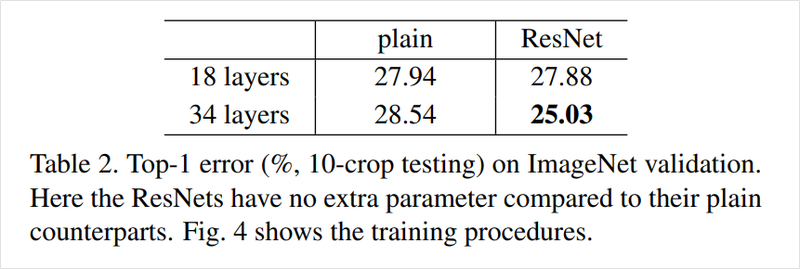

## 1. ResNet 기본 블록 구성하기
ResNet-34와 ResNet-50 네트워크를 직접 만든다고 할 때, 두 모델의 구성은 다음과 같다.
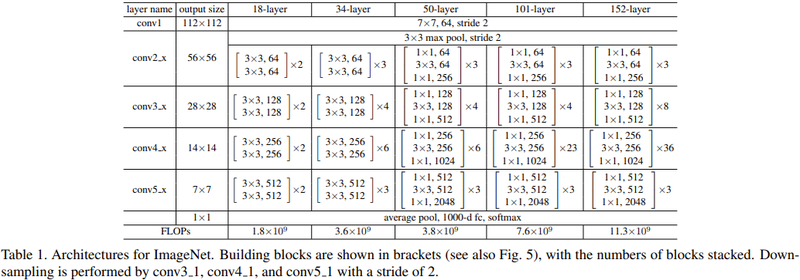

* ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있다.
* 그러나 ResNet-34의 경우 Block은 3x3 kernal인 Convolution Layer로만 구성되어 있지만 ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 된다.


In [1]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

## 1. Convolution Block 만들기

In [2]:
#function for building Convolution Block

def build_conv_block(input_layer,
                     channel=64,
                     kernal_size=3,
                     strides=1,
                     activation='relu',
                     block_num=1,
                     unit_num=1,
                     stage_num=1):
        
    #입력 레이어
    x = input_layer

    #CNN 레이어
    x = keras.layers.Conv2D(channel, kernal_size, strides, padding = 'same',
                           name = f'stage{stage_num}_{unit_num}_Conv{block_num}')(x)
    
    #Batch Normalization
    x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{unit_num}_BN{block_num}')(x)
    
    if activation: # 유닛의 마지막 블럭은 add 이후 activation이 들어가므로 activation을 제외할 수 있어야 한다.
        x = keras.layers.Activation(activation=activation,
                                    name = f'stage{stage_num}_{unit_num}_ReLU{block_num}')(x)
        
    return x

## 2. ResNet 기본 블록 구성

In [3]:
def build_residual_unit(input_layer,
                        unit_num=1,
                        stage_num=1,
                        is_50=True,
                        channel=64):
    #input
    x = input_layer
    
    if is_50:
        for unit in range(unit_num):
            if unit == 0: # 유닛의 첫 번째 레이어에서는 stride = 2
                skip_layer = build_conv_block(x, channel*4, 1, 2, False, 0, unit+1, stage_num)
                # 해당 유닛의 마지막 출력과 더해진 후 activation 되어야 한다.
                x = build_conv_block(x, channel, 1, 2, 'relu', 1, unit+1, stage_num)
            else:
                skip_layer = x
                x = build_conv_block(x, channel, 1, 1, 'relu', 1, unit+1, stage_num)
            x = build_conv_block(x, channel, 3, 1, 'relu', 2, unit+1, stage_num)
            x = build_conv_block(x, channel*4, 1, 1, False, 3, unit+1, stage_num)
            # skip_layer와 더해진 후 activation 되어야 한다.
            x = keras.layers.Add(name = f'stage{stage_num}_Add{unit+1}')([x, skip_layer])
            x = keras.layers.Activation('relu',
                                        name = f'stage{stage_num}_{unit+1}_ReLU3')(x)
            
    else:
        for unit in range(unit_num):
            if stage_num > 2 and unit == 0:
                # 첫번째 유닛을 제외한 유닛의 첫 번째 레이어에서는 stride = 2
                skip_layer = build_conv_block(x, channel, 1, 2, False, 0, unit+1, stage_num)
                x = build_conv_block(x, channel, 3, 2, 'relu', 1, unit+1, stage_num)
            else:
                skip_layer = x
                # 첫 번째 유닛은 maxpooling 후 입력되므로 strides=1
                x = build_conv_block(x, channel, 3, 1, 'relu', 1, unit+1, stage_num)
                
            x = build_conv_block(x, channel, 3, 1, False, 2, unit+1, stage_num)
            x = keras.layers.Add(name= f'stage{stage_num}_Add{unit+1}')([x, skip_layer])
            x = keras.layers.Activation('relu', name=f'stage{stage_num}_{unit+1}_ReLU2')(x)
    
    return x

## 3. ResNet 모델 구성

In [4]:
def build_resnet(input_shape = (32, 32, 3), is_50 = True, num_classes = 10):
    if num_classes == 1: # 이진 분류일 때
        activation = 'sigmoid'
    else:                # 다중 분류일 때
        activation = 'softmax'
        
    unit_num = [3,4,6,3] # 한 유닛에 쌓이는 conv_block의 개수
    input_layer = keras.layers.Input(shape=input_shape)
    x = input_layer
    
    x = build_conv_block(x, 64, 7, 2)
    x = keras.layers.MaxPool2D(pool_size=2,
                               strides=2,
                               name='stage1_1_maxpooling')(x)
    
    for i, unit in enumerate(unit_num):
        stage = i + 2
        channel = 64*(2**i) # channel=[64, 126, 256, 512]
        x = build_residual_unit(x, unit, stage, is_50, channel)
        
    x = keras.layers.AveragePooling2D((1,1), name='Avg_Pool')(x)
    x = keras.layers.Flatten(name='Flatten')(x)
    x = keras.layers.Dense(num_classes,
                           activation=activation,
                           name='predictions')(x)
    
    # 모델 이름 다르게 출력
    if is_50:
        model = keras.Model(inputs=input_layer, outputs=x, name='ResNet50')
    else:
        model = keras.Model(inputs=input_layer, outputs=x, name='ResNet34')
        
    return model

### (1) ResNet 50-Layer Summary

In [5]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)
resnet_50.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_Conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
stage1_1_BN1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_Conv1[0][0]             
__________________________________________________________________________________________________
stage1_1_ReLU1 (Activation)     (None, 16, 16, 64)   0           stage1_1_BN1[0][0]               
___________________________________________________________________________________________

### (2) ResNet 34-Layer Summary

In [6]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False)
resnet_34.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_Conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
stage1_1_BN1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_Conv1[0][0]             
__________________________________________________________________________________________________
stage1_1_ReLU1 (Activation)     (None, 16, 16, 64)   0           stage1_1_BN1[0][0]               
___________________________________________________________________________________________

## 4. PlainNet 기본 블록 구성

In [7]:
def build_plain_unit(input_layer,
                   unit_num=1,
                   stage_num=1,
                   is_50=True,
                   channel=64):
    x = input_layer

    if is_50:
        for unit in range(unit_num):
            if unit == 0:
                #skip_layer = build_conv_block(x,channel*4,1,2,False,0,unit+1,stage_num)
                x = build_conv_block(x,channel,1,2,'relu',1,unit+1,stage_num)
                
            else:
                #skip_layer = x
                x = build_conv_block(x,channel,1,1,'relu',1,unit+1,stage_num)

            x = build_conv_block(x,channel,3,1,'relu',2,unit+1,stage_num)            
            x = build_conv_block(x,channel*4,1,1,'relu',3,unit+1,stage_num)
            #x = keras.layers.Add(name = f'stage{stage_num}_Add{unit+1}')([x, skip_layer])
            #x = keras.layers.Activation('relu', name = f'stage{stage_num}_{unit+1}_ReLU3')(x)
    
    else:
        for unit in range(unit_num):
            if stage_num > 2 and unit == 0:
                #skip_layer = build_conv_block(x,channel,1,2,False,0,unit+1,stage_num)
                x = build_conv_block(x,channel,3,2,'relu',1,unit+1,stage_num)
                
            else:
                #skip_layer = x
                x = build_conv_block(x,channel,3,1,'relu',1,unit+1,stage_num)
            
            x = build_conv_block(x,channel,3,1,'relu',2,unit+1,stage_num)
            #x = keras.layers.Add(name = f'stage{stage_num}_Add{unit+1}')([x, skip_layer])
            #x = keras.layers.Activation('relu', name = f'stage{stage_num}_{unit+1}_ReLU2')(x)

    return x

## 5. PlainNet 모델 구성

In [8]:
def build_plainnet(input_shape=(32,32,3), is_50=True, num_classes=10):
    if num_classes == 1:
        activation='sigmoid'
    else:
        activation='softmax'
    unit_num = [3,4,6,3]
    with tf.name_scope('Input Layer'):
        input_layer = keras.layers.Input(shape=input_shape)
    x = input_layer
    #if is_50:
    #    x = keras.layers.ZeroPadding2D()

    with tf.name_scope('Stage1'):
        with tf.name_scope('Stage1_Conv1_64,7,2'):
            x = build_conv_block(x,64,7,2)
        with tf.name_scope('Stage1_Pool'):
            x = keras.layers.MaxPool2D(pool_size=2, 
                                       strides=2,
                                       name = 'stage1_1_maxpooling')(x)

    for i, unit in enumerate(unit_num):
        stage = i+2
        channel = 64*(2**i)
        x = build_plain_unit(x,unit,stage,is_50,channel)

    x = keras.layers.AveragePooling2D((1,1), name = 'Avg_Pool')(x)
    x = keras.layers.Flatten(name='Flatten')(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           name='predictions')(x)
    
    if is_50:
        model = keras.Model(inputs=input_layer, outputs=x, name='PlainNet50')
    else:
        model = keras.Model(inputs=input_layer, outputs=x, name='PlainNet34')

    return model

### (1) PlainNet 34-Layer Summary

In [9]:
plainnet_34 = build_plainnet(input_shape=(32,32,3), is_50=False)
plainnet_34.summary()

Model: "PlainNet34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
stage1_1_Conv1 (Conv2D)      (None, 16, 16, 64)        9472      
_________________________________________________________________
stage1_1_BN1 (BatchNormaliza (None, 16, 16, 64)        256       
_________________________________________________________________
stage1_1_ReLU1 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
stage1_1_maxpooling (MaxPool (None, 8, 8, 64)          0         
_________________________________________________________________
stage2_1_Conv1 (Conv2D)      (None, 8, 8, 64)          36928     
_________________________________________________________________
stage2_1_BN1 (BatchNormaliza (None, 8, 8, 64)          2

### (2) PlainNet 50-Layer Summary

In [10]:
plainnet_50 = build_plainnet(input_shape=(32,32,3), is_50=True)
plainnet_50.summary()

Model: "PlainNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
stage1_1_Conv1 (Conv2D)      (None, 16, 16, 64)        9472      
_________________________________________________________________
stage1_1_BN1 (BatchNormaliza (None, 16, 16, 64)        256       
_________________________________________________________________
stage1_1_ReLU1 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
stage1_1_maxpooling (MaxPool (None, 8, 8, 64)          0         
_________________________________________________________________
stage2_1_Conv1 (Conv2D)      (None, 4, 4, 64)          4160      
_________________________________________________________________
stage2_1_BN1 (BatchNormaliza (None, 4, 4, 64)          2

## 6. 데이터셋 준비

In [11]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [12]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [13]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_val))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [14]:
# 모델에 넣어주기 전 정규화(normalize)

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224]) # 이미지 리사이징 까먹지말기!
    return tf.cast(image, tf.float32) / 255., label

In [15]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [16]:
# 카테고리 개수 확인

ds_info.features["label"].num_classes

2

In [17]:
# 카테고리 이름 확인

ds_info.features["label"].names

['cat', 'dog']

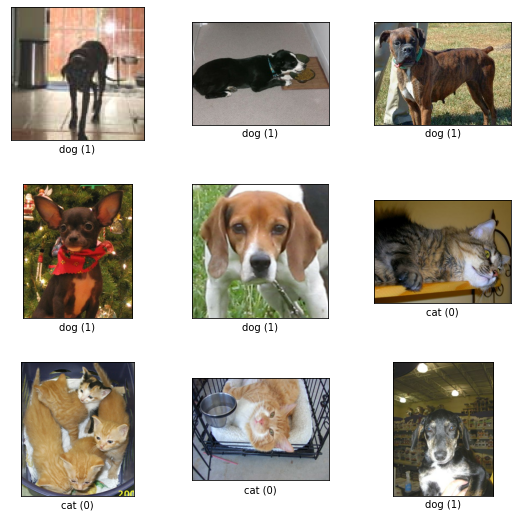

In [18]:
# 트레인 이미지 샘플 확인

fig = tfds.show_examples(ds_train, ds_info)

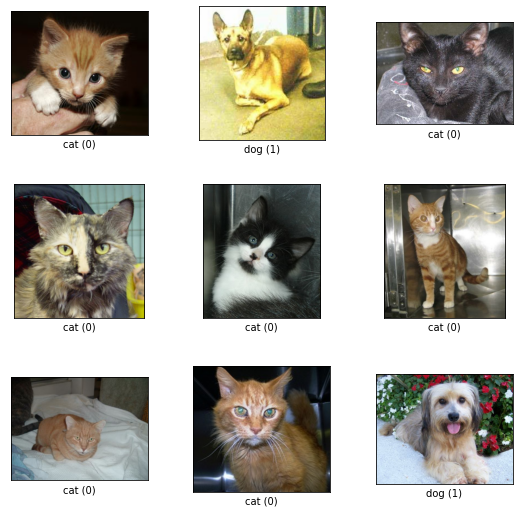

In [19]:
# 테스트 이미지 샘플 확인

fig = tfds.show_examples(ds_val, ds_info)

In [20]:
BATCH_SIZE = 32
EPOCH = 40

In [21]:
# cats_vs_dogs 데이터셋 만들기

(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_val = apply_normalize_on_dataset(ds_val, batch_size=BATCH_SIZE)

In [22]:
# cats_vs_dogs

plainnet_34 = build_plainnet(input_shape=(224,224,3), is_50=False, num_classes=1)

plainnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
    # callbacks=[tensorboard_callback]
)

Epoch 1/40
581/581 [==============================] - 283s 439ms/step - loss: 0.7673 - accuracy: 0.5167 - val_loss: 1.2145 - val_accuracy: 0.5227
Epoch 2/40
581/581 [==============================] - 235s 405ms/step - loss: 0.7566 - accuracy: 0.5319 - val_loss: 1.2064 - val_accuracy: 0.5017
Epoch 3/40
581/581 [==============================] - 235s 405ms/step - loss: 0.7539 - accuracy: 0.5223 - val_loss: 1.4434 - val_accuracy: 0.4808
Epoch 4/40
581/581 [==============================] - 235s 405ms/step - loss: 0.7483 - accuracy: 0.5265 - val_loss: 1.1033 - val_accuracy: 0.5294
Epoch 5/40
581/581 [==============================] - 235s 405ms/step - loss: 0.7405 - accuracy: 0.5287 - val_loss: 1.0330 - val_accuracy: 0.5439
Epoch 6/40
581/581 [==============================] - 235s 405ms/step - loss: 0.7311 - accuracy: 0.5520 - val_loss: 0.9325 - val_accuracy: 0.5610
Epoch 7/40
581/581 [==============================] - 235s 405ms/step - loss: 0.6866 - accuracy: 0.6223 - val_loss: 1.7165 -

In [23]:
plainnet_50 = build_plainnet(input_shape=(224,224,3), is_50=True, num_classes=1)

plainnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
    # callbacks=[tensorboard_callback]
)

Epoch 1/40
581/581 [==============================] - 242s 346ms/step - loss: 0.7654 - accuracy: 0.5136 - val_loss: 5.7321 - val_accuracy: 0.4926
Epoch 2/40
581/581 [==============================] - 162s 278ms/step - loss: 0.7581 - accuracy: 0.5219 - val_loss: 7.2489 - val_accuracy: 0.4933
Epoch 3/40
581/581 [==============================] - 162s 279ms/step - loss: 0.7666 - accuracy: 0.5068 - val_loss: 1.4436 - val_accuracy: 0.5401
Epoch 4/40
581/581 [==============================] - 162s 279ms/step - loss: 0.7781 - accuracy: 0.5027 - val_loss: 1.9302 - val_accuracy: 0.5074
Epoch 5/40
581/581 [==============================] - 162s 279ms/step - loss: 0.7616 - accuracy: 0.5146 - val_loss: 1.5978 - val_accuracy: 0.5030
Epoch 6/40
581/581 [==============================] - 161s 278ms/step - loss: 0.7533 - accuracy: 0.5257 - val_loss: 4.9025 - val_accuracy: 0.4914
Epoch 7/40
581/581 [==============================] - 162s 278ms/step - loss: 0.7576 - accuracy: 0.5234 - val_loss: 3.2202 -

In [24]:
resnet_34 = build_resnet(input_shape=(224,224,3), is_50=False, num_classes=1)

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
    # callbacks=[tensorboard_callback]
)

Epoch 1/40
581/581 [==============================] - 265s 430ms/step - loss: 0.9143 - accuracy: 0.5481 - val_loss: 0.8759 - val_accuracy: 0.5565
Epoch 2/40
581/581 [==============================] - 245s 422ms/step - loss: 0.8123 - accuracy: 0.6047 - val_loss: 2.5404 - val_accuracy: 0.5147
Epoch 3/40
581/581 [==============================] - 245s 422ms/step - loss: 0.7799 - accuracy: 0.6240 - val_loss: 1.0211 - val_accuracy: 0.6190
Epoch 4/40
581/581 [==============================] - 245s 422ms/step - loss: 0.7087 - accuracy: 0.6579 - val_loss: 0.8113 - val_accuracy: 0.6626
Epoch 5/40
581/581 [==============================] - 245s 422ms/step - loss: 0.6472 - accuracy: 0.6985 - val_loss: 0.7105 - val_accuracy: 0.6752
Epoch 6/40
581/581 [==============================] - 246s 423ms/step - loss: 0.5672 - accuracy: 0.7283 - val_loss: 0.6688 - val_accuracy: 0.6797
Epoch 7/40
581/581 [==============================] - 245s 422ms/step - loss: 0.4837 - accuracy: 0.7762 - val_loss: 0.6524 -

In [25]:
resnet_50 = build_resnet(input_shape=(224,224,3), is_50=True, num_classes=1)

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
    # callbacks=[tensorboard_callback]
)

Epoch 1/40
581/581 [==============================] - 205s 320ms/step - loss: 0.9845 - accuracy: 0.5173 - val_loss: 0.9325 - val_accuracy: 0.5076
Epoch 2/40
581/581 [==============================] - 187s 322ms/step - loss: 0.9200 - accuracy: 0.5338 - val_loss: 2.0706 - val_accuracy: 0.5345
Epoch 3/40
581/581 [==============================] - 184s 317ms/step - loss: 0.8922 - accuracy: 0.5415 - val_loss: 1.8049 - val_accuracy: 0.5457
Epoch 4/40
581/581 [==============================] - 184s 317ms/step - loss: 0.8631 - accuracy: 0.5587 - val_loss: 0.8855 - val_accuracy: 0.5446
Epoch 5/40
581/581 [==============================] - 184s 317ms/step - loss: 0.8472 - accuracy: 0.5574 - val_loss: 1.7674 - val_accuracy: 0.5647
Epoch 6/40
581/581 [==============================] - 184s 317ms/step - loss: 0.8256 - accuracy: 0.5684 - val_loss: 1.8644 - val_accuracy: 0.5522
Epoch 7/40
581/581 [==============================] - 184s 317ms/step - loss: 0.8073 - accuracy: 0.5914 - val_loss: 1.0437 -

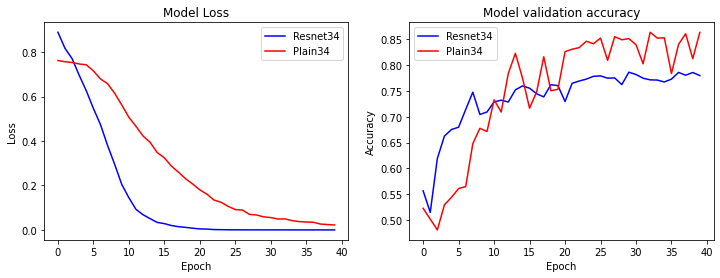

In [26]:
# ResNet34 vs PlainNet34
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_res34.history['loss'], 'b')
plt.plot(history_plain34.history['loss'], 'r')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet34', 'Plain34'])


plt.subplot(1, 2, 2)
plt.plot(history_res34.history['val_accuracy'], 'b')
plt.plot(history_plain34.history['val_accuracy'], 'r')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet34', 'Plain34'])

plt.show()

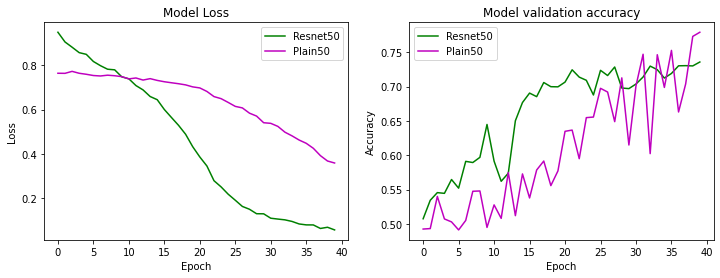

In [27]:
# ResNet50 vs PlainNet50
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_res50.history['loss'], 'g')
plt.plot(history_plain50.history['loss'], 'm')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet50', 'Plain50'])


plt.subplot(1, 2, 2)
plt.plot(history_res50.history['val_accuracy'], 'g')
plt.plot(history_plain50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet50', 'Plain50'])

plt.show()

## 결론
* Training Loss 및 Accuracy의 경우 확실히 PlainNet보다 ResNet의 정확도가 매우 높음을 확인할 수 있다.
* 하지만 Validation Loss 및 Accuracy의 경우 전반적으로 PlainNet의 결과가 더 좋았다.
* ResNet 학습 중 Overfitting으로 인한 Val Accuracy가 떨어졌다고 생각된다.